In [1]:
import jax  # Autodiff, easy batching of functions
import jax.numpy as jnp  # Like numpy but written to run fast on GPU
import numpy as np
import distrax  # Tensorflow probability for Jax
import haiku as hk  # Used for making neural nets
import tqdm  # Used for reporting training progress
import chex  # Used for checking dimensions, useful for debugging
from jax.scipy.linalg import cholesky  # Need to structure covariance appropriately for learning
from matplotlib import pyplot as plt
from functools import partial
from matplotlib import pyplot as plt
import optax  # Used for optimization using SGD, Adam etc

# plt.style.use('seaborn-v0_8-deep')

%matplotlib inline

### notes

- why does the fit gaussian have this shape not matter where the target is?
- we can play with the $\beta$ for the KL penalty, if this goes above ~200 we see a pull from the prior
- the prior log prob seems to make no difference to the solution
- 

### policy gradient with KL penalty

The prior is a mixture of $N$ components, and the policy is a Gaussian:

\begin{align}
    \pi_0(x) \propto p(x|\mathbf{\mu}, \mathbf{\Sigma}) &= \sum_i^N{w_i\mathcal{N}(\mu_i, \Sigma_i)} \\ 
    \sum_i{w_i} &= 1 \\
    \pi(x) &\propto p(x|\mu_p, \Sigma_p) = \mathcal{N}(\mu_p, \Sigma_p)
\end{align}

Fit GMM to data to serve as the prior, $x_prior$.

Train the policy distribution using reward:

\begin{align} 
    r(x,t) &= -|t - x|^2
\end{align}
<!-- return -jnp.sum(jnp.subtract(a, target_params["loc"])**2,axis=1) -->

given $t$ the target

and loss function to minimize:

\begin{align}
   \mathcal{L}(a,r,p_{policy},p_{prior}) &= -\sum_k{r_k(\log{p(a_k|p_{policy})} + \log{p(a_k|p_{prior})})} \\
   \\ &+ \beta * \mathcal{KL}(p_{prior},p_{policy})
\end{align}
<!-- return -(rewards * (log_probs)).sum() + alpha*penalty -->

where the KL penalty is sum over prior components:

$$
    \mathcal{KL}(p_{prior},p_{policy}) = \sum_k{w_k}\mathcal{D}_{KL}(\mathcal{N}(\mu_p,\Sigma_p),\mathcal{N}(\mu_k,\Sigma_k))
$$
<!-- penalty += weight*component.kl_divergence(dist_model) -->

gradient update: 

$$
\theta_{policy}' = \theta_{policy} + \nabla_{\theta}(\mathcal{L})
$$
<!-- Probably a more accurate line here -->

In [125]:
ACTION_DIM = 2
batch_size = 500
key = jax.random.PRNGKey(1)

In [222]:
def transform_to_cov(sq_mat):
    return jnp.dot(sq_mat.T, sq_mat)


@jax.jit
def normal_policy_log_prob(params, actions, prior_params):
  chex.assert_shape(actions, (None,ACTION_DIM))

  dist_prior = distrax.MultivariateNormalTri(
        loc=jnp.array(prior_params['loc']), scale_tri=(prior_params['scale'])
        )

  dist_model = distrax.MultivariateNormalTri(
      loc=jnp.array(params['loc']), scale_tri=(params['scale'])
      )

  log_probs_prior = dist_prior.log_prob(actions)
  log_probs_model = dist_model.log_prob(actions)
  chex.assert_shape(log_probs_prior, (actions.shape[0],))
  chex.assert_shape(log_probs_model, (actions.shape[0],))

  return log_probs_model + log_probs_prior

@jax.jit
def mixture_policy_log_prob(params, actions, prior_params):
  chex.assert_shape(actions, (None,ACTION_DIM))

  dist_prior = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(
          probs=(prior_params["mixture_probs"])),
        components_distribution = distrax.MultivariateNormalTri(
          loc=prior_params["means"],scale_tri=(prior_params["scales"])),
        )

  dist_model = distrax.MultivariateNormalTri(
      loc=jnp.array(params['loc']), scale_tri=(params['scale'])
      )

  log_probs_prior = dist_prior.log_prob(actions)
  log_probs_model = dist_model.log_prob(actions)
  chex.assert_shape(log_probs_prior, (actions.shape[0],))
  chex.assert_shape(log_probs_model, (actions.shape[0],))

  return log_probs_model + log_probs_prior

@partial(jax.jit, static_argnums=(2,))
def policy_sample(rng, params, num_samples):
  """See policy log prob."""
  eps = 1e-4
  samples = distrax.MultivariateNormalTri(
      loc=params['loc'],
      scale_tri=(params['scale'])
      ).sample(seed=rng, sample_shape=(num_samples,))
  chex.assert_shape(samples, (num_samples, ACTION_DIM))
  return samples

@partial(jax.jit, static_argnums=(3,))
def policy_sample_hierarchical(rng, params, prior_params, num_samples):
  """See policy log prob."""
  prior_samples = make_prior_dist(prior_params).sample(seed=rng, sample_shape=(num_samples,))
  policy = lambda mean: distrax.MultivariateNormalTri(loc=mean, scale_tri=(params['scale']))
  policy_samples = jnp.array([policy(s).sample(seed=key,sample_shape=(1,)).reshape((2)) for s in prior_samples])
  chex.assert_shape(policy_samples, (num_samples, ACTION_DIM))
  return policy_samples


@partial(jax.jit, static_argnums=(2,))
def univariate_policy_sample(rng, params, num_samples):
  mu = jnp.array(params['loc'])
  sigma = (jnp.array(params['scale']))

  eps = 1e-4
  samples = distrax.Normal(loc=mu, scale=sigma).sample(seed=rng, sample_shape=(num_samples,)).reshape(-1)
  chex.assert_shape(samples, (num_samples,))

  return samples

def kl_penalty(params, prior_params):
  dist_prior = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=(prior_params["mixture_probs"])),
        components_distribution = distrax.MultivariateNormalTri(loc=prior_params["means"],scale_tri=(prior_params["scales"])),
        )

  dist_model = distrax.MultivariateNormalTri(
      loc=jnp.array(params['loc']), scale_tri=(params['scale'])
      )
  
  penalty = 0
  for weight, component in zip(dist_prior.mixture_distribution.probs, dist_prior.components_distribution):
    penalty += weight*component.kl_divergence(dist_model)

  return penalty

def kl_penalty_proper(params, prior_params, n_samples=5000):
    dist_prior = distrax.MixtureSameFamily(
          mixture_distribution = distrax.Categorical(probs=(prior_params["mixture_probs"])),
          components_distribution = distrax.MultivariateNormalTri(loc=prior_params["means"],scale_tri=(prior_params["scales"])),
          )
    dist_policy = distrax.MultivariateNormalTri(
        loc=jnp.array(params['loc']), scale_tri=(params['scale'])
        )
    
    # This is one way!
    # # sample from the prior, this is what we're taking the expectation under!
    # prior_samples = dist_prior.sample(seed=key, sample_shape=(n_samples,))
    # # get log probs under the prior and policy  
    # prior_x = dist_prior.log_prob(prior_samples)
    # policy_x = dist_policy.log_prob(prior_samples)
    # return jnp.mean(prior_x - policy_x)

    # This is the other way
    # sample from the policy, this is what we're taking the expectation under!
    policy_samples = dist_policy.sample(seed=key, sample_shape=(n_samples,))
    # get log probs under the prior and policy  
    prior_x = dist_prior.log_prob(policy_samples)
    policy_x = dist_policy.log_prob(policy_samples)
    return jnp.mean(policy_x - prior_x)

def loss_fn(params, actions, rewards, prior_params, alpha):
  chex.assert_shape(actions, (batch_size,ACTION_DIM))
  chex.assert_shape(rewards, (batch_size,))
  log_probs = mixture_policy_log_prob(params, actions, prior_params)
  # penalty = kl_penalty(params, prior_params)
  # penalty = kl_penalty_proper(params, prior_params)
  chex.assert_shape(log_probs, (batch_size,))
  rewards = jax.lax.stop_gradient(rewards)  # Don't backprop through the reward function
  # log probs are always negative! rewards are negated, so we end up with a positive
  # KL distance is positive, so we leave this to minimize
  # negative the whole thing because we're minimizing this quantity
  return (rewards * -log_probs).sum() # + alpha*penalty

@jax.jit
def get_rewards(a, target_params, key):
  # # sample from target distribution, compute distances, sum (effectively averages)
  # target_dist = distrax.MultivariateNormalTri(
  #     loc=jnp.array(target_params['loc']), scale_tri=(target_params['scale'])
  #     )
  # target_samples = target_dist.sample(seed=key, sample_shape=(a.shape[0],))
  # # maximize the negative of the error (minimize the error)
  # return -jnp.sum(jnp.subtract(a, target_samples)**2,axis=1)
  # subtract from target distribution mean
  return -jnp.sum(jnp.subtract(a, target_params["loc"])**2,axis=1)

@jax.jit  # This compiles the function to the GPU
def update_fn(params, actions, rewards, opt_state, prior_params, alpha, wlr=1e-4, epsilon=1e-8):
  optimizer = optax.adam(wlr)
  loss = loss_fn(params, actions, rewards, prior_params, alpha=alpha)
  grads = jax.grad(loss_fn)(params, actions, rewards, prior_params, alpha)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  params['scale'] = jnp.clip(params['scale'], a_min=epsilon)  # Clip for numerical stability
  return params, opt_state, loss


def setup_params():
    mixture_probs = jnp.array([0.1,0.9])
    mixture_means = [[10.,25.],[-10., -25.]]
    mixture_scales = jnp.linalg.cholesky(jnp.array([[[5.0,0.0],
                                                     [0.0,5.0]],
                                                    [[5.0,0.0],
                                                    [0.0,5.0]]]))
    mixture_params = {
        "mixture_probs" : (mixture_probs),
        "means" : mixture_means,
        "scales" : (mixture_scales)
    }

    starting_mean = jnp.array([10.,-10.])
    starting_sigma = 10.0
    starting_scale = jnp.linalg.cholesky(jnp.array([[1.0,  0.0],
                                                    [0.0,  1.0]]))*starting_sigma
    params = {
        'loc': starting_mean,
        'scale': (starting_scale)
        }

    target_position = jnp.array([30.0,10.0])
    target_scale = jnp.linalg.cholesky(jnp.array([[15.0,  -14.],
                                                  [-14.,  15.0]]))
    target_params = {
        'loc': target_position,
        'scale': (target_scale)
    }
    return mixture_params, params, target_params

def plot_samples(dist,num_samples,label,rng):
  # split for new samples
  key, subkey = jax.random.split(rng)
  samples = dist.sample(seed=subkey, sample_shape=(num_samples,)).T
  plt.scatter(samples[0],samples[1],label=label)

def make_target_dist(target_params):
    return  distrax.MultivariateNormalTri(
    loc=target_params['loc'],
    scale_tri=(target_params['scale']))

def make_prior_dist(mixture_params):
   return distrax.MixtureSameFamily(
    mixture_distribution = distrax.Categorical(probs=(mixture_params["mixture_probs"])),
    components_distribution = distrax.MultivariateNormalTri(loc=mixture_params["means"],scale_tri=(mixture_params["scales"])))

def make_starting_dist(starting_params):
    return distrax.MultivariateNormalTri(
    loc=starting_params['loc'],
    scale_tri=(starting_params['scale']))
   

In [229]:
mixture_params, params, target_params = setup_params()

In [230]:
num_iter = 5000
learning_rate = 1e-2
opt_state = optax.adam(learning_rate).init(params)
losses = np.zeros(num_iter)
rewards = np.zeros(num_iter)
params_list = []

for t in tqdm.tqdm(range(num_iter)):
  key, subkey = jax.random.split(key)
  actions_t = policy_sample(rng=subkey, params=params, num_samples=batch_size)
  # actions_t = policy_sample_hierarchical(rng=subkey, params=params, prior_params=mixture_params, num_samples=batch_size)
  rewards_t = get_rewards(actions_t, target_params, key)
  rewards[t] = rewards_t.mean()
  params_list.append(params)
  params, opt_state, loss_t = update_fn(params, actions_t, rewards_t, opt_state, alpha=0.01, prior_params=mixture_params, wlr=learning_rate)
  losses[t] = loss_t
  params_list.append(params)
means = np.array([[p["loc"][0],p["loc"][1]] for p in params_list]).T

 51%|█████     | 2550/5000 [00:10<00:09, 248.91it/s]

IndexError: list index out of range

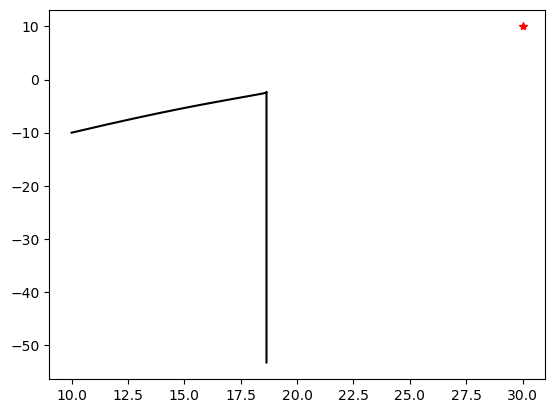

In [ ]:
# def plot_2d_dist(dist):
#   xl = jnp.linspace(-20,20,100)
#   yl = jnp.linspace(-20,20,100)
#   x, y = jnp.meshgrid(xl, yl)
#   X = jnp.stack([xm.flatten(), ym.flatten()], axis=-1)
#   probs = dist.prob(X).reshape((101, 101))
#   left,right,bottom,top = xl.min(), xl.max(), yl.min(), yl.max()
#   plt.imshow(probs, extent=(left,right,bottom,top), origin="lower")
#   _ = plt.gca().set_xticks(xl[::10],labels=np.round(xl[::10]),rotation=45)
#   _ = plt.gca().set_yticks(yl[::10],labels=np.round(yl[::10]),rotation=45)

plt.figure()
plt.plot(means[0],means[1],"k-")
plt.plot(target_params["loc"][0],target_params["loc"][1],"r*")
plt.plot(params_list[0]["loc"][0],params_list[0]["loc"][1],"g*")

plt.figure()
plt.plot(losses,"k-")
plt.title("Loss")

# plt.figure()
# plt.plot([kl_penalty(p,mixture_params) for p in params_list])
# plt.title("KL Penalty")

plt.figure()
plt.plot(rewards,"k-")
plt.title("Reward")

plt.figure(figsize=(10,10))
plt.gca().set_aspect("auto")

plot_samples(make_prior_dist(mixture_params),1000,"Mixture Prior",rng=key)
plot_samples(make_target_dist(target_params),1000,"Target",rng=key)
plot_samples(make_starting_dist(params_list[0]),1000,"Starting",rng=key)
plt.plot(target_params["loc"][0],target_params["loc"][1],"r*",label="Target Mean")

middle_dist = distrax.MultivariateNormalTri(
    loc=params_list[500]['loc'],
    scale_tri=(params_list[500]['scale']),
    )
plot_samples(middle_dist,1000,"Middle",key)

late_dist = distrax.MultivariateNormalTri(
    loc=params_list[-100]['loc'],
    scale_tri=(params_list[-100]['scale']),
    )
plot_samples(late_dist,1000,"Late",key)

fitted_dist = distrax.MultivariateNormalTri(
    loc=params['loc'],
    scale_tri=(params['scale']),
    )
plot_samples(fitted_dist,1000,"Fit",key)

plt.plot([p["loc"][0] for p in params_list],[p["loc"][1] for p in params_list],"k--")
plt.plot(target_params["loc"][0],target_params["loc"][1],"r*",markersize=15)

plt.legend()